# Using Linear Regression to Predict MLB Wins By a Team's Statistics

In the notebook we are going to use statistics from every 162 game MLB season to draw a relationship between a team's statistics and their total wins. Ultiately we will use this information to extrapolate over the covid-truncated 2020 team statistics to determine which teams benefitted from the shortened season.

### Import everything

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_formats = ['svg']
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data
I sourced my data from [Baseball Reference]("https://www.baseball-reference.com/") using BeautifulSoup and Selenium to scrape. That process can be found in my [scraping file](Team_Season_Data_Scraping.ipynb). I pickled the data as dataframes and will be importing and unpickling in this notebook.

## Target and Features 

In very basic terms linear regression models "take in" features and try to predict a target. <br>
In this case our target is easy - the number of wins a team has in a season. <br>
For our features we will start by analyzing what I will call the "Pure Statistics". These are the "building blocks" of baseball. While they all will have a relationship with runs scored, and wins, none of them on their own (with the exception of home runs) actually produce any runs.

- PA (Plate Appearances) 
- 1B (Singles)
- 2B (Doubles)
- 3B (Triples)
- HR (Home Runs)
- BB (Walks)
- SB (Stolen Bases)
- SO (StrikeOuts)

> Note: We will also be looking at how teams GAVE UP these stats. So we will have two of each of the stats, stats for a team and stats AGAINST a team.. 

# Pure Stats Model

In [4]:
# The stats columns we will want for our dataframes
pure_stats = ['W', 'G', 'PA', '1B', '2B', '3B', 'HR','BB', 'SB', 'SO']
pure_stats_against = ['PA_A', '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']

In [5]:
complete_df = pd.read_pickle("full_comined_baseball_stats.pkl")
complete_df.columns

Index(['Year', 'Team', 'W', 'G', 'PA', '1B', '2B', '3B', 'HR', 'BB', 'SB',
       'SO', 'BA', 'OBP', 'SLG', 'PA_A', '1B_A', '2B_A', '3B_A', 'HR_A',
       'BB_A', 'SB_A', 'SO_A', 'BA_A', 'OBP_A', 'SLG_A'],
      dtype='object')

In [6]:
# grab all the seasons that have 162 games (a full season)
all_games = complete_df[complete_df['G']==162].reset_index(drop=True)
# split off 20 percent for final testing
all_games, test_seasons = train_test_split(all_games, test_size=.2)

In [7]:
# This is what our data looks like
all_games

,Year,Team,W,G,PA,1B,2B,3B,HR,BB,...,1B_A,2B_A,3B_A,HR_A,BB_A,SB_A,SO_A,BA_A,OBP_A,SLG_A
851,1971,PIT,97,162,38.8,6.89,1.38,0.38,0.95,2.90,...,6.858025,1.098765,0.179012,0.666667,2.901235,0.259259,5.018519,0.257,0.316,0.357
833,2001,PIT,62,162,37.2,5.51,1.58,0.15,0.99,2.88,...,6.049383,1.913580,0.222222,1.030864,3.388889,0.598765,5.604938,0.272,0.344,0.433
424,2016,KCR,81,162,37.4,6.21,1.63,0.20,0.91,2.36,...,5.913580,1.530864,0.129630,1.271605,3.191358,0.339506,7.944444,0.259,0.327,0.423
1006,1984,STL,84,162,37.6,6.33,1.39,0.27,0.46,3.19,...,6.530864,1.419753,0.277778,0.580247,3.049383,0.771605,4.987654,0.262,0.324,0.373
1097,2002,TOR,78,162,38.5,5.73,1.88,0.23,1.15,3.22,...,6.086420,1.925926,0.179012,1.092593,3.641975,0.660494,6.117284,0.269,0.344,0.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,2013,ANA,78,162,38.6,6.19,1.67,0.24,1.01,3.23,...,6.179012,1.765432,0.129630,1.030864,3.290123,0.808642,7.407407,0.261,0.328,0.408
1061,1993,TEX,86,162,38.1,5.98,1.75,0.24,1.12,2.98,...,6.327160,1.716049,0.179012,0.888889,3.469136,0.586420,5.907407,0.267,0.337,0.405
795,1993,PHI,97,162,40.3,6.50,1.83,0.31,0.96,4.10,...,6.197531,1.524691,0.240741,0.796296,3.537037,0.623457,6.895062,0.252,0.322,0.378
975,1982,SEA,76,162,38.2,6.23,1.60,0.20,0.80,2.81,...,6.135802,1.475309,0.154321,1.067901,3.376543,0.728395,6.185185,0.256,0.324,0.401


### Lets look at the correlations

In [8]:
# The combined features we will be examining
combined_features = ['PA', '1B', '2B', '3B', 'HR','BB', 'SB', 'SO', 
                     'PA_A', '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']

In [9]:
all_games[['W'] + combined_features].corr()[['W']]

,W
W,1.000000
PA,0.388321
1B,0.185527
2B,0.172020
3B,0.061960
HR,0.256624
BB,0.354099
SB,0.140918
SO,-0.115309
PA_A,-0.485421


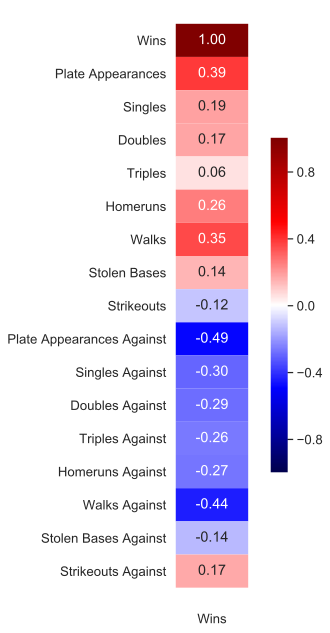

In [10]:
# plot heat map of pure stats compared to wins
y_axis_labels = ["Wins", "Plate Appearances", "Singles", "Doubles", "Triples", "Homeruns", "Walks", "Stolen Bases", "Strikeouts",
                 "Plate Appearances Against", "Singles Against", "Doubles Against", "Triples Against", "Homeruns Against", "Walks Against", "Stolen Bases Against", "Strikeouts Against"]
f, ax = plt.subplots(figsize=(2, 11))
ax = sns.heatmap(all_games[['W'] + combined_features].corr()[['W']], cmap="seismic", annot=True, vmin=-1, vmax=1,  
                 fmt=".2f", yticklabels=y_axis_labels, xticklabels=["Wins"],
                cbar_kws = dict(pad=.2), )
ax.set_ylim(len(all_games[['W'] + combined_features].corr()[['W']])+.5, -.5)
plt.yticks(rotation=0);
# plt.savefig('pure_stats_corr.png', bbox_inches = "tight", dpi=500);

Right off the bat it looks like everything that should be positively correlated is while everything that should be negatively correlated is indeed negatively correlated. Its interesting to note the heavy correlation between Walks and wins.

In [ ]:
# Next we can look at the pairplots to see if we find any interesting relationships
sns.pairplot(all_games[pure_stats]);

There is nothing that jumps off the page there as needing a transformation. Plate Appearences appear to have a linear relationship with lots of the other features, this may cause issues. We will keep that in mind as we hop into our linear regression.

## Least Squares Model
We will start by looking at a simple least squares model

In [20]:
# Lets first make a function to create models

def linear_create_validate(features, target, random_state=None):
    """
    Takes a features dataframe and a target data frame as inputs
    Returns the fitted model and the linear regression model
    """
    
    # create the training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25, random_state=random_state)
    
    # set up the model and fir it with training set
    lr = LinearRegression()
    model = lr.fit(features_train, target_train)
    
    # check the score on the validation set
    val_score = lr.score(features_val, target_val)
    print("Validate Score: ", val_score)
    
    # check the score on the training set
    training_score = lr.score(features_train, target_train)
    print("Training Score: ", training_score)
    
    # run on the hold out test set
    predicted_vals = model.predict(features_val)
    
    return({
        "Model": model, 
        "LR": lr, 
        "Predicted": predicted_vals, 
        "Actual": target_val
    })

In [21]:
# set the features and target
features = all_games[combined_features]
target = all_games['W']

In [27]:
linear_model_dict = linear_create_validate(features, target, random_state=10)

Validate Score:  0.8190326514048845
Training Score:  0.8164626409032556


If you run the above cell a few times you will see that our validation scores and training scores both hover right around the low .8's <br>
The fact that neither is consistently higher than the other tells us that our model is probably not over or under fitting. IE no lasso/ridge/polynomial needed

Lets now scale the data to see how important each feature is

In [14]:
# scale the data
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [28]:
# feed the scaled features into the function
scaled_model_dict = linear_create_validate(scaled_features, target, random_state=10)

Validate Score:  0.8190326514048842
Training Score:  0.8164626409032556


Good news is that the scores have not changed, so we can be confident we scaled correctly. (Scaling should not affect scores) <br>
Lets take a look at the coefficents

In [39]:
# print out the coefficents with the corresponding feature
for c in zip( combined_features, scaled_model_dict["LR"].coef_):
    print(c[0], c[1])

PA -2.8650909536200246
1B 4.791387142434526
2B 3.5352434359254565
3B 1.0299587447342047
HR 6.982114308492971
BB 4.176072162335252
SB 1.2926985861495406
SO -0.7888987532376996
PA_A 3.24210128594892
1B_A -5.2377733750025905
2B_A -3.881508094384231
3B_A -1.5700879293085201
HR_A -5.98717316773328
BB_A -4.518165168326481
SB_A -1.1560747101122433
SO_A 0.05918079237246204


We notice something odd with Plate Appearences here. They seem to be working opposite as they should. Plate appearences appears NEGATIVELY correlated with wins while plate appearences against appears POSITIVELY correlated with wins. I suspect this is due to Plate Appearences being colinear with nearly every other statistic. Let's toss it and see what happens.

## Remove Plate Appearence Feature

In [30]:
# The combined features without plate appearence
combined_features_nopa = ['1B', '2B', '3B', 'HR','BB', 'SB', 'SO', 
                     '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']

In [31]:
# set the features and target
features = all_games[combined_features_nopa]
target = all_games['W']

In [33]:
linear_model_nopa_dict = linear_create_validate(features, target, random_state=8)

Validate Score:  0.7930504263850179
Training Score:  0.8171004853419294


It appears as though taking out the plate appearences did not affect our model's score. Thats good news.

## Analyze Residuals

In [94]:
# Find our residuals for data our model has never seen
precicted_wins = linear_model_nopa_dict["Predicted"]
actual_wins = linear_model_nopa_dict["Actual"]
win_diff = precicted_wins - actual_wins

In [95]:
# we see that our model is on average within about 4 wins... not bad
win_diff.abs().describe()

count    230.000000
mean       3.630110
std        2.950559
min        0.030720
25%        1.383067
50%        2.716257
75%        5.319564
max       15.428481
Name: W, dtype: float64

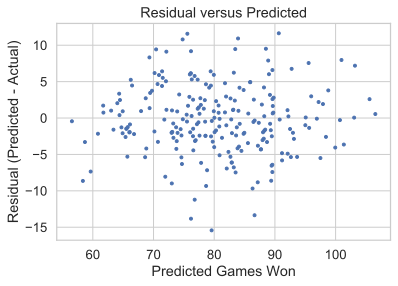

In [96]:
# plot the residuals
plt.xlabel('Predicted Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Predicted')
plt.plot(precicted_wins, win_diff, '.');

We can see that our residuals are pretty evenly distrubted when compared to their predictions. Thats a good sign. However when we plot the residuals with respect to the actual values we see an issue...

In [105]:
lr = LinearRegression()
fit_model = lr.fit(actual_wins.values.reshape(-1, 1), win_diff)
lr.coef_, lr.intercept_

(array([-0.18125699]), 14.374569110608276)

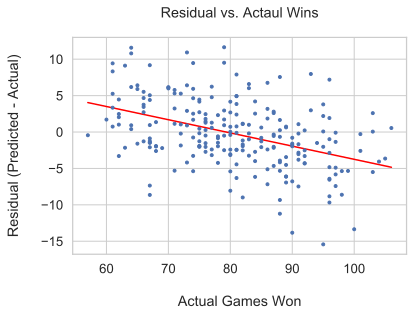

In [106]:
# plot the residuals
plt.xlabel('Actual Games Won', labelpad=20)
plt.ylabel('Residual (Predicted - Actual)', labelpad=20)
plt.title('Residual vs. Actaul Wins', pad =20)
plt.plot(actual_wins,fit_model.predict(actual_wins.values.reshape(-1, 1)), color="red")
plt.plot(actual_wins, win_diff, '.')
plt.savefig('residuals_pure_1.png', bbox_inches = "tight", dpi=500);

### Little Issue
When plotted versus their ACTUAL wins we can see that the residuals actually have a negative trend. <br>
### What this means
This tells me that our model over predicts worse teams and under predicts the better teams. Let's see if we can fix this.

# Feature Engineering
So far we have just been analyzing the "Pure Statistics", and have created a pretty good linear model. But we can also "engineer" these features to gather more insight. We will begin with a Polynomial interpotation. 

In [41]:
# Lets first make a function to create models

def polynomial_create_validate(features, target):
    """
    Takes a features dataframe and a target data frame as inputs
    Returns the fitted model and the polynomial regression model
    """
    
    # create the training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25)
    
    poly = PolynomialFeatures(degree=2)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)
    
    
    
    # set up the model and fit it with training set
    lr = LinearRegression()
    model = lr.fit(features_train_poly, target_train)
    
    # check the score on the validation set
    val_score = lr.score(features_val_poly, target_val)
    print("Validate Score: ", val_score)
    
    # check the score on the training set
    training_score = lr.score(features_train_poly, target_train)
    print("Training Score: ", training_score)
    
    # run on the hold out test set
    predicted_vals = model.predict(features_val_poly)
    
    return({
        "Model": model, 
        "LR": lr, 
        "Predicted": predicted_vals, 
        "Actual": target_val
    })

In [38]:
# Lets first make a function to create models

def polynomial_ridge_create_validate(features, target, alphas=(.1, 1, 10)):
    """
    Takes a features dataframe and a target data frame as inputs
    Returns the fitted model and the polynomial regression model
    """
    
    # create the training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25)
    
    poly = PolynomialFeatures(degree=2)
    features_train_poly = poly.fit_transform(features_train)
    features_val_poly = poly.transform(features_val)
    
    std = StandardScaler()
    train_poly_scale = std.fit_transform(features_train_poly)
    val_poly_scale = std.transform(features_val_poly)

    
    # set up the model and fit it with training set
    lr_ridge = RidgeCV(alphas = alphas)
    model = lr_ridge.fit(train_poly_scale, target_train)
    
    print("Alpha: ", lr_ridge.alpha_)
    
    # check the score on the validation set
    val_score = lr_ridge.score(val_poly_scale, target_val)
    print("Validate Score: ", val_score)
    
    # check the score on the training set
    training_score = lr_ridge.score(train_poly_scale, target_train)
    print("Training Score: ", training_score)
    
    # run on the hold out test set
    predicted_vals = lr_ridge.predict(val_poly_scale)
    
    return({
        "Model": model, 
        "LR": lr_ridge, 
        "Predicted": predicted_vals, 
        "Actual": target_val
    })

# Polynomial engineering on pure stats

In [42]:
features = all_games[combined_features_nopa]
target = all_games["W"]

In [43]:
poly_pure_stats_model = polynomial_create_validate(features, target)

(690, 120)
Validate Score:  0.7924488786035278
Training Score:  0.8513022370924236


Above we are over fitting. The Training score is higher than the validation score. This means our modeling is getting really good with the trainig data, but not generalizing enough for the validation set (data it was not trained on). To "loosen" it up we will try a ridge regression.

In [44]:
poly_ridge_pure_stats_model = polynomial_ridge_create_validate(features, target, alphas=(20, 30, 40 , 50, 60))

Alpha:  60
Validate Score:  0.8009979301531132
Training Score:  0.8178901149828296


This helps the overfitting but it doesnt help the scores from the original model

In [52]:
# Find our residuals for data our model has never seen
precicted_wins = poly_ridge_pure_stats_model["Predicted"]
actual_wins = poly_ridge_pure_stats_model["Actual"]
win_diff = precicted_wins - actual_wins

In [53]:
win_diff.abs().describe()

count    230.000000
mean       4.028901
std        3.001354
min        0.031142
25%        1.687269
50%        3.353454
75%        6.013135
max       15.443299
Name: W, dtype: float64

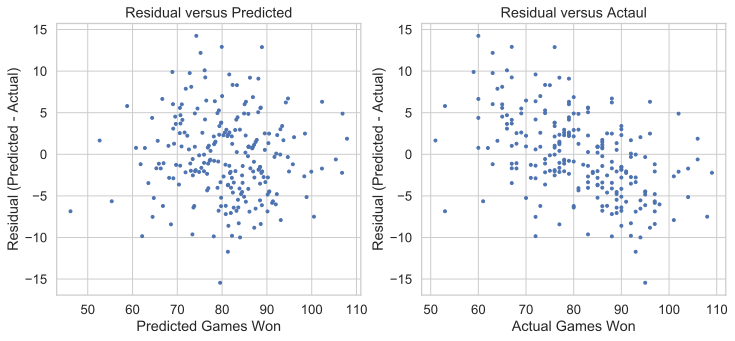

In [54]:
plt.figure(figsize=(12,5))

# plot the residuals
ax1=plt.subplot(1, 2, 1)
plt.xlabel('Predicted Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Predicted')
plt.plot(precicted_wins, win_diff, '.');

# plot the residuals
ax2=plt.subplot(1, 2, 2)
plt.xlabel('Actual Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Actaul')
plt.plot(actual_wins, win_diff, '.');

# Domain Knowledge
Baseball has a slew of commonly used statistics that are really just combinations of these "Pure Statistics", i.e. feature engineering.
I will be analyzing three common "Average Statistics" :

- BA (Batting Average) ( Hits / At-Bats )
- OBP (ON Base Percentage) ( (Hits + Walks) / Plate Appearences )
- SLG (Slugging Percentage ( (1B + 2* 2B + 3* 3B + 4* HR) / At-Bats )

In [45]:
avg_stats = ['W', 'G', 'BA', 'OBP', 'SLG']
avg_stats_against = ['BA_A', 'OBP_A', 'SLG_A']

### Lets Explore the Correlations

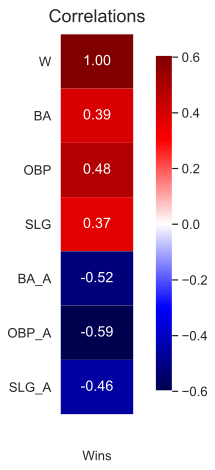

In [47]:
# lets see how the features correlate with wins
combined_features_avgs = ['BA', 'OBP', 'SLG', 'BA_A', 'OBP_A', 'SLG_A']
f, ax = plt.subplots(figsize=(2, 8))
ax = sns.heatmap(all_games[['W'] + combined_features_avgs].corr()[['W']], 
                 cmap="seismic", annot=True, vmin=-.6,  vmax=.6,  fmt=".2f", xticklabels=["Wins"],
                cbar_kws = dict(pad=.2), )
ax.set_ylim(len(all_games[['W'] + combined_features_avgs].corr()[['W']])+.5, -.5)
plt.title('Correlations', pad=-15, fontsize=18)
plt.yticks(rotation=0);

It is interesting to see how On Base Percentage is much more correlated than Batting average, as they are fairly similar statistics. The primary difference is On Base Percentage factors in walks which Batting average does not. This is consistent with our findings with the pure statistics, where walks were highly correlated with wins. (This is what money ball discovered)

In [ ]:
sns.pairplot(all_games[['W', 'BA', 'OBP', 'SLG']]);

Unsurprisingly there is a lot of collinierity going on. These averages are describing the same statistics in slightly different ways. Let's see how this affects the modelling.

## Least Squares Model
We will start again by looking at a simple least squares model

In [48]:
# set the features and target
features = all_games[combined_features_avgs]
target = all_games['W']

In [49]:
# scale the data
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [50]:
# feed the scaled features into the function
scaled_model_dict_avgs = linear_create_validate(scaled_features, target)

Validate Score:  0.8304375374849603
Training Score:  0.8141445650173884


Once again our scores are hovering around the low .8's. Lets look at the coefficents

In [51]:
# print out the coefficents with the corresponding feature
for c in zip( combined_features_avgs, scaled_model_dict["LR"].coef_):
    print(c[0], c[1])

BA -3.5113299238264055
OBP 5.48326828746753
SLG 3.6072024515946866
BA_A 0.8091579664890315
OBP_A 7.312436000031594
SLG_A 4.393949191894004


We see that our batting average coefficents are funny. Batting average is negatively correlated with wins while Batting average against is quite small. Once again this is telling me that Batting Average is very colinear with the other two stats and our model is telling us that OBP and SLugging are a better predictor. 
>This is exactly what they discovered in money ball OBP is a better predictor than Batting Average

## Remove Batting Average 

In [61]:
combined_features_noba = ['OBP', 'SLG', 'BA_A', 'OBP_A']
# set the features and target
features = all_games[combined_features_noba]
target = all_games['W']

In [62]:
# scale the data
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [63]:
# feed the scaled features into the function
scaled_model_dict_avgs_noba = linear_create_validate(scaled_features, target)

Validate Score:  0.7332377030219106
Training Score:  0.7862672636842647


Removing the batting average has actually hurt our model's score. It is now in the high 70's. So Let's keep it in.

## Check Residuals on Model with BA
Ok so now we have looked at feature engineered models. Our score has not really changed... But has it improved the issue we were seeing with our residuals

In [52]:
# Find our residuals for data our model has never seen
precicted_wins = scaled_model_dict_avgs["Predicted"]
actual_wins = scaled_model_dict_avgs["Actual"]
win_diff = precicted_wins - actual_wins

In [53]:
win_diff.abs().describe()

count    230.000000
mean       3.563536
std        2.755361
min        0.010235
25%        1.341547
50%        2.807319
75%        5.293586
max       11.719707
Name: W, dtype: float64

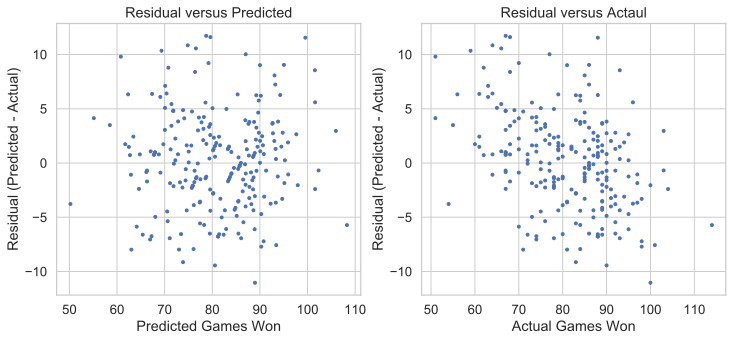

In [54]:
plt.figure(figsize=(12,5))

# plot the residuals
ax1=plt.subplot(1, 2, 1)
plt.xlabel('Predicted Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Predicted')
plt.plot(precicted_wins, win_diff, '.');

# plot the residuals
ax2=plt.subplot(1, 2, 2)
plt.xlabel('Actual Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Actaul')
plt.plot(actual_wins, win_diff, '.');

Again, we see the same issue, where the residuals trend downward as the actual games won increases. Again our model over predicts the worse teams and under predicts the better teams.

So there's not much different between the "pure stats" model and the "engineered stats" model...  

# Combined Pure and Engineered

Let's just throw the kitchen sink at this model. Add together the "Pure Stats" and the "Engineered Stats" into one model!

In [67]:
all_features = ['1B', '2B', '3B', 'HR','BB', 'SB', 'SO', 'BA','OBP', 'SLG',
                          '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A', 'BA_A','OBP_A', 'SLG_A']

In [68]:
features = all_games[all_features]
target = all_games['W']
all_features_linear_model = linear_create_validate(features, target)

Validate Score:  0.8322445061395739
Training Score:  0.8291801554743368


This model does seem to be preforming slightly better. Lets check the coefficents and residuals

In [69]:
for c in zip(all_features,all_features_linear_model["LR"].coef_ ):
    print(c[0],c[1])

1B -10.51455447370787
2B -14.15208777098482
3B -17.16353100635557
HR -13.591845213610458
BB -0.8877215828048982
SB 3.4588559867448203
SO -0.567894891450833
BA 337.0215670433209
OBP 296.6302711127567
SLG 225.58839109108843
1B_A 12.620190129202596
2B_A 16.26767645432893
3B_A 9.892777194271119
HR_A 15.835124387794519
BB_A -1.2593885005555265
SB_A -3.86844599639934
SO_A -0.28335408674394835
BA_A -552.3635833810039
OBP_A -214.3164611550267
SLG_A -200.17190098187228


WOAH THERE!! These coefficents make no logical sense. This is probably because of the over colinearity between the "engineered" stats and the "pure" stats.

In [70]:
precicted_wins = all_features_linear_model["Predicted"]
actual_wins = all_features_linear_model["Actual"]
win_diff = precicted_wins - actual_wins

In [71]:
win_diff.abs().describe()

count    230.000000
mean       3.618104
std        2.714034
min        0.030612
25%        1.441006
50%        2.896344
75%        5.110788
max       14.216577
Name: W, dtype: float64

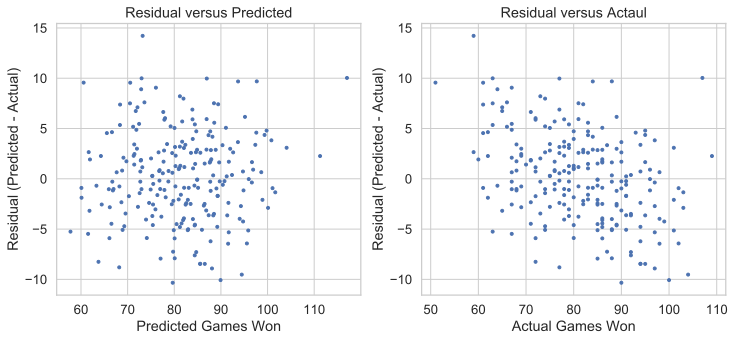

In [72]:
plt.figure(figsize=(12,5))

# plot the residuals
ax1=plt.subplot(1, 2, 1)
plt.xlabel('Predicted Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Predicted')
plt.plot(precicted_wins, win_diff, '.');

# plot the residuals
ax2=plt.subplot(1, 2, 2)
plt.xlabel('Actual Games Won')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual versus Actaul')
plt.plot(actual_wins, win_diff, '.');

We still can't escape this negative residual trend. And although the model seems to be predicting slightly better, the fact that the coefficents are starting to make no sense and we didn't fix the residual issue lead me to back track to the model with only "engineered stats"

# Analyzing and Evaluating the Model
Now that we know which model we want to use (pure linear) and which features (pure and engineered, no polynomials) lets analyze 

In [119]:
combined_features_avgs = ['BA', 'OBP', 'SLG', 'BA_A', 'OBP_A', 'SLG_A']
features = all_games[combined_features_avgs]
target = all_games['W']

In [120]:
# create a model on all 80% of data
final_lr = LinearRegression()
final_model = final_lr.fit(features, target)

In [121]:
# Let's look at how our model scores on data it has never seen
print("Score new data: ", final_lr.score(test_seasons[combined_features_avgs], test_seasons['W']))

Score new data:  0.809900120796059


In [76]:
# Let's see the difference between predicted vs actual wins, i.e. the residuals
win_diff = final_model.predict(test_seasons[combined_features_avgs]) - test_seasons['W']
win_diff.abs().describe()

count    230.000000
mean       3.991444
std        3.108521
min        0.018298
25%        1.673943
50%        3.202798
75%        5.748185
max       15.311601
Name: W, dtype: float64

So our model can predict the number of wins a team will have within about 4 wins on AVERAGE. With a std dev of 2.9 games, about 85% of our predictions land within 6.5 games of the actual values. These are all pretty good numbers.

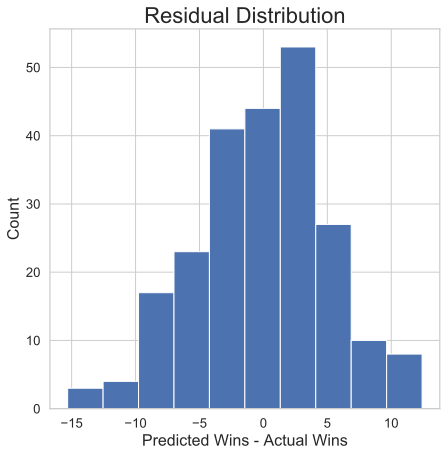

In [77]:
plt.figure(figsize=(7,7))
plt.xlabel('Predicted Wins - Actual Wins', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Residual Distribution', fontsize=22)
plt.hist(win_diff,bins=10);

We also see a pretty normal distribution of the residuals. It is centered a bit greater than zero.

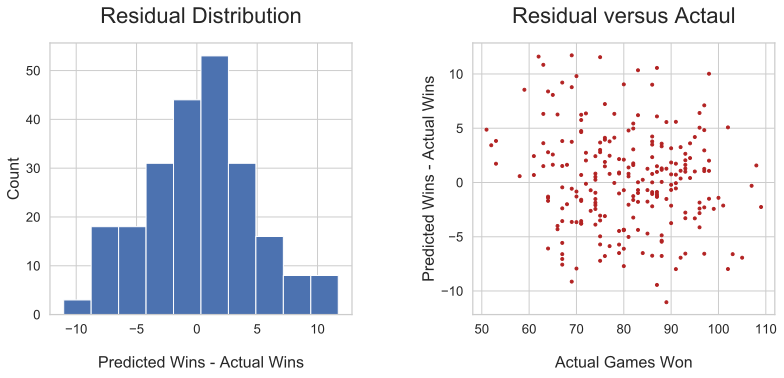

In [55]:
plt.figure(figsize=(13,5))
plt.subplots_adjust(wspace=.4)

# plot the residuals
ax1=plt.subplot(1, 2, 1)
plt.xlabel('Predicted Wins - Actual Wins',labelpad=20, fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Residual Distribution', pad=20, fontsize=22)
plt.hist(win_diff,bins=10);

# plot the residuals
ax2=plt.subplot(1, 2, 2)
plt.ylabel('Predicted Wins - Actual Wins', fontsize=16)
plt.xlabel('Actual Games Won', labelpad=20, fontsize=16)
plt.title('Residual versus Actaul', pad=20, fontsize=22)
plt.plot(test_seasons['W'], win_diff, '.', color="firebrick")
plt.savefig('residuals_avg_2.png', bbox_inches = "tight", dpi=500);

While our residuals are evenly distributed with respect to our predictions, there is still that negative trajectory when we plot it with respect to the actual values. This is something I just could not shake... Let's take one final look at what the coefficents are telling us.

In [79]:
# create a scaled model on all 80% of data
features = all_games[combined_features_avgs]
test_features = test_seasons[combined_features_avgs]
target = all_games['W']
test_target = test_seasons['W']

std = StandardScaler()
train_scale = std.fit_transform(features)
test_scale = std.transform(test_features)

final_lr_scaled = LinearRegression()
final_model_scaled = final_lr_scaled.fit(train_scale, target)

In [80]:
# scaled model score is the same as before, thats perfect
print("Score new data: ", final_lr_scaled.score(test_scale,test_target))

Score new data:  0.8099001207960592


In [81]:
for c in zip(combined_features_avgs, final_lr_scaled.coef_):
    print(c[0], c[1])

BA -0.34914704759543125
OBP 4.648673779691019
SLG 5.084450397323263
BA_A 0.6552464238275497
OBP_A -5.549956422560821
SLG_A -4.964345753731974


This is VERY interesting and is what we have been seeing throughout this notebook. BA and OBP are very similar stats, but my model shows that OBP is far more indicative of win percentage than BA. While walks may be boring, they are clearly very important!

# Applying The Model
Lets apply this model to the 2020 data

In [82]:
# take the 2020 seasons
complete_2020 = complete_df[complete_df['Year']==2020]
complete_2020;

Use my model to predict the number of wins a team will have over the next 102 games (to complete a full season)

In [83]:
# estimate the predicted wins over the next 102 games
pred_wins = final_model.predict(complete_2020[combined_features_avgs])*102/162

Create a predicted wins column which is the teams current wins plus the wins my model predicted over the next 102 games

In [84]:
complete_2020["predicted_wins"] = pred_wins + complete_2020["W"]

Create a column of extrapolated wins. Simply their current win% extrapolated over a 162 game season

In [85]:
complete_2020["extrapolated_wins"] = complete_2020["W"]*162/60

Create a column with the diofference between our projected wins and extrapolated wins

In [86]:
complete_2020["win_diff"] = complete_2020["extrapolated_wins"] - complete_2020["predicted_wins"]

In [87]:
complete_2020 = complete_2020.reset_index(drop=True)

In [88]:
# On avg a teams projected wins will land within 4.5 games of their extrapolated wins
complete_2020["win_diff"].abs().describe()

count    30.000000
mean      4.325389
std       3.523093
min       0.403163
25%       1.854259
50%       3.245053
75%       5.833075
max      13.502759
Name: win_diff, dtype: float64

Lets plot the Projected Games won over Current Games Won. The blue line represents the extrapolated wins. A team above the line has been getting "unlucky" and would expect to improve their win% as the year went on. Teams below that line have been getting "lucky" and should expect the opposite

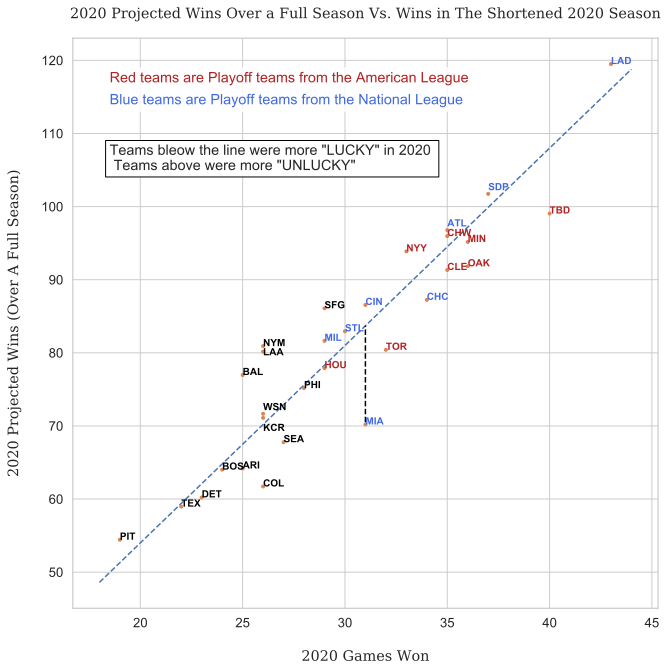

In [142]:


plt.figure(figsize=(10.5,10.5))

tred = plt.text(18.5, 117, "Red teams are Playoff teams from the American League",color='firebrick')
tred.set_bbox(dict(facecolor='white', alpha=.8))

tblue = plt.text(18.5, 114, "Blue teams are Playoff teams from the National League", color='royalblue')
tblue.set_bbox(dict(facecolor='white', alpha=.8))

t1 = plt.text(18.5, 105, 'Teams bleow the line were more "LUCKY" in 2020 \n Teams above were more "UNLUCKY"', )
t1.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))

plt.xlabel("2020 Games Won", family='serif', labelpad=20 )
plt.ylabel("2020 Projected Wins (Over A Full Season)", family='serif', labelpad=20 )
plt.title("2020 Projected Wins Over a Full Season Vs. Wins in The Shortened 2020 Season", family='serif', pad=20)
plt.plot(range(18,45), [(x*162/60) for x in range(18,45)], ls='--')
plt.plot(complete_2020["W"], complete_2020["predicted_wins"], '.')
plt.plot([31,31],[70.5, 83.7], '--' , color="black")

for i, txt in enumerate(complete_2020["Team"]):
    y_buffer = 0
    color = "black"
    playoff_teams = ["CHW", "MIN", "CLE", "LAD", "SDP", "TBD", "ATL", "NYY", 
                     "OAK", "CIN", "CHC", "FLA", "STL", "MIL", "HOU", "TOR"]
    benefitted_teams = ["CLE", "TOR", "HOU", "STL", "MIL", "FLA"]
    
    american_league = ["CHW", "MIN", "CLE", "TBD", "NYY", "OAK", "HOU", "TOR"]
    national_league = ["LAD", "SDP", "ATL", "CIN", "CHC", "FLA", "STL", "MIL"]
    
    
    if txt in american_league:
        color="firebrick"
    if txt in national_league:
        color="royalblue"
        
    if txt == "FLA":
        txt = "MIA"
    elif txt == "ANA":
        txt = "LAA"
        y_buffer = -.5
    elif txt== "WSN":
        y_buffer = .5
    elif txt=="KCR":
        y_buffer = -1.8
    elif txt=="ATL":
        y_buffer = .5
    elif txt=="SDP":
        y_buffer = .5
    plt.annotate(txt, (complete_2020["W"][i], complete_2020["predicted_wins"][i]+y_buffer), 
                 fontsize=10, color=color, fontweight="bold")
#plt.savefig('final_plot.png', bbox_inches = "tight", dpi=500);

# What Does This Tell US?

- Teams above the line had been "under-preforming" their stats through the first 60 games and would expect to "progress" if the season were allowed to continue

- Teams below the line were "over-preforming" their stats and we would expect them to "regress" as the seaso. continues

- The Marlins were the "luckiest" team of 2020, they finished the season with a winning record and made the playoffs. If the season were 162 games my model would have them not only missing the playoffs, but finishing the season with a losing record.

- The Dodgers were projected to break the record of most wins in an MLB season